## Data Preprocessing

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from geopy.geocoders import Nominatim
import ast

Load temperature data by city

In [70]:
climate_data = pd.read_csv('public/data/GlobalLandTemperaturesByCity.csv')
climate_data = climate_data.drop(['Latitude', 'Longitude'], axis=1)
climate_data = climate_data.drop_duplicates(['City', 'dt'])
climate_data['dt'] = pd.to_datetime(climate_data['dt'])
min_date = climate_data['dt'].min()
max_date = climate_data['dt'].max()
print(len(climate_data))
climate_data.head(3)

8455054


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country
0,1743-11-01,6.068,1.737,Århus,Denmark
1,1743-12-01,NaN,NaN,Århus,Denmark
2,1744-01-01,NaN,NaN,Århus,Denmark


### Example for seasonal imputation

In [58]:
climate_data_denmark = climate_data[(climate_data.Country == 'Denmark') & (climate_data.City == 'Århus')]
climate_data_denmark.head(3)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country
0,1743-11-01,6.068,1.737,Århus,Denmark
1,1743-12-01,NaN,NaN,Århus,Denmark
2,1744-01-01,NaN,NaN,Århus,Denmark


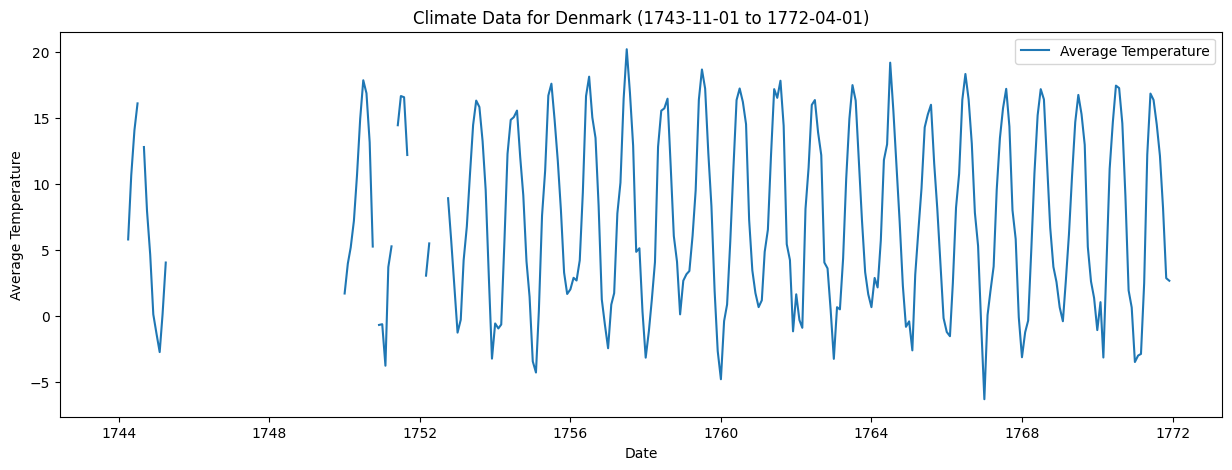

In [59]:
climate_data_denmark = climate_data_denmark[climate_data_denmark['dt'] < '1772-01-01']
plt.figure(figsize=(15, 5))
plt.plot(climate_data_denmark['dt'], climate_data_denmark['AverageTemperature'], label='Average Temperature')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Climate Data for Denmark (1743-11-01 to 1772-04-01)')
plt.legend()
plt.show()

Add all months of the timespan to the dataframe

In [60]:
all_dates = pd.date_range(start=min_date, end=max_date, freq='MS') 
all_dates_df = pd.DataFrame(all_dates, columns=['dt'])

complete_climate_data_denmark = pd.merge(all_dates_df, climate_data_denmark, on='dt', how='left')
complete_climate_data_denmark.sort_values(by='dt', inplace=True)

Perform seasonal imputation

In [61]:
climate_data_denmark['InterpolatedTemp'] = climate_data_denmark['AverageTemperature'].interpolate(method='linear')

# Perform seasonal decomposition on the interpolated data
decomposition = seasonal_decompose(climate_data_denmark['InterpolatedTemp'], model='additive', period=12)

# Get seasonal component
seasonal = decomposition.seasonal

# Subtract the seasonal component, interpolate the original missing values, and then add the seasonal component back
climate_data_denmark['FilledTemp'] = climate_data_denmark['AverageTemperature'] - seasonal
climate_data_denmark['FilledTemp'].interpolate(method='linear', inplace=True)
climate_data_denmark['FilledTemp'] += seasonal
climate_data_denmark['AverageTemperature'].fillna(climate_data_denmark['FilledTemp'], inplace=True)
climate_data_denmark.drop(['InterpolatedTemp', 'FilledTemp'], axis=1, inplace=True)

Visualize resulst

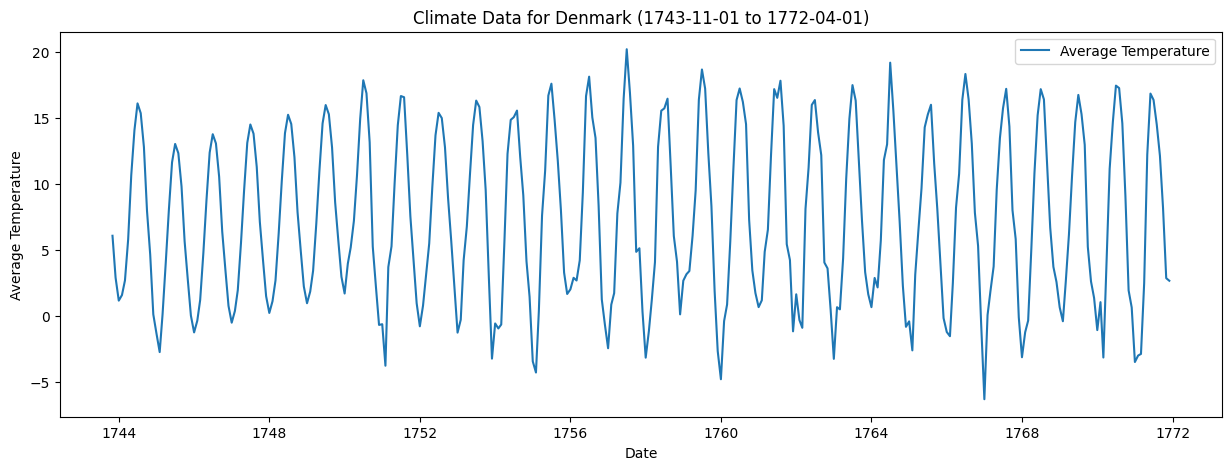

In [62]:
climate_data_denmark = climate_data_denmark[climate_data_denmark['dt'] < '1772-01-01']
plt.figure(figsize=(15, 5))
plt.plot(climate_data_denmark['dt'], climate_data_denmark['AverageTemperature'], label='Average Temperature')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Climate Data for Denmark (1743-11-01 to 1772-04-01)')
plt.legend()
plt.show()

### Impute values on entire dataframe

In [76]:
city_data_list = []
cities = []
countries = []
temperatures = []

for country in climate_data['Country'].unique():
    country_data = climate_data[climate_data['Country'] == country]
    for city in country_data['City'].unique():
        cities.append(city)
        countries.append(country)
        city_data = country_data[country_data['City'] == city]
        city_complete_data = pd.merge(all_dates_df, city_data, on='dt', how='left')
        
        # Forward fill, then interpolate, and finally backward fill
        city_complete_data['InterpolatedTemp'] = (city_complete_data['AverageTemperature']
                                                  .fillna(method='ffill')
                                                  .interpolate(method='linear')
                                                  .fillna(method='bfill'))
        
        # Apply seasonal decomposition on the interpolated data
        decomposition = seasonal_decompose(city_complete_data['InterpolatedTemp'], model='additive', period=12, extrapolate_trend='freq')
        seasonal = decomposition.seasonal
        
        # Subtract the seasonal component, interpolate the original missing values, and then add the seasonal component back
        city_complete_data['FilledTemp'] = city_complete_data['AverageTemperature'] - seasonal
        city_complete_data['FilledTemp'] = city_complete_data['FilledTemp'].interpolate(method='linear') + seasonal
        
        # Finalize the DataFrame
        city_complete_data['AverageTemperature'] = city_complete_data['FilledTemp']
        city_complete_data = city_complete_data[['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country']]
        
        mean_temperature = city_complete_data['AverageTemperature'].mean()
        city_complete_data['AverageTemperature'].fillna(value=mean_temperature, inplace=True)

        city_data_list.append(city_complete_data)

        temperatures.append(city_complete_data['AverageTemperature'].values.tolist())

# Concatenate all processed city data
processed_data = pd.concat(city_data_list)

/var/folders/72/cssf9khd09z6smrvmjwffm5r0000gn/T/ipykernel_92329/2716927230.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/var/folders/72/cssf9khd09z6smrvmjwffm5r0000gn/T/ipykernel_92329/2716927230.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill'))
/var/folders/72/cssf9khd09z6smrvmjwffm5r0000gn/T/ipykernel_92329/2716927230.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/var/folders/72/cssf9khd09z6smrvmjwffm5r0000gn/T/ipykernel_92329/2716927230.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill'))
/var/folders/72/cssf9khd09z6sm

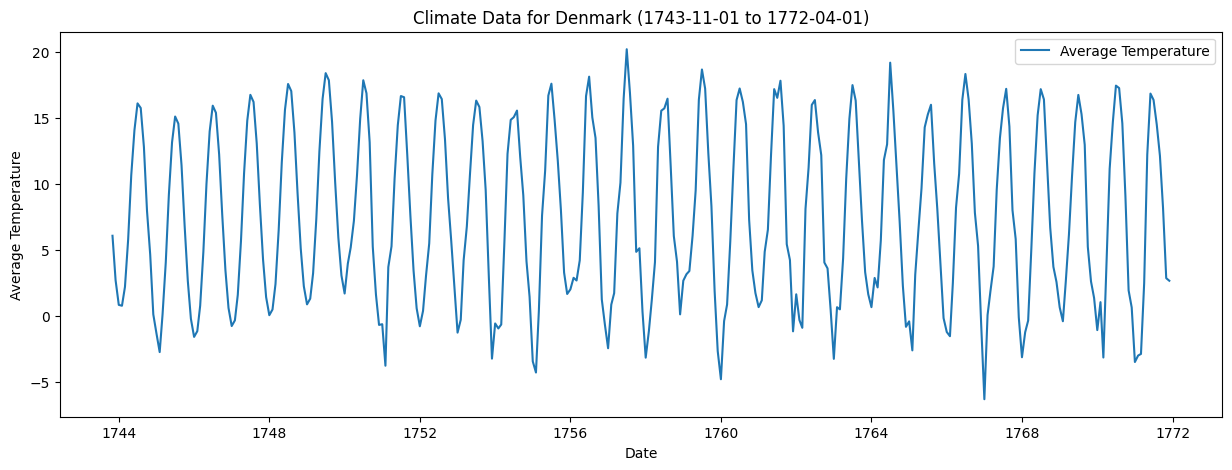

In [77]:
climate_data_denmark = processed_data[processed_data.City == 'Århus']
climate_data_denmark = climate_data_denmark[climate_data_denmark['dt'] < '1772-01-01']
plt.figure(figsize=(15, 5))
plt.plot(climate_data_denmark['dt'], climate_data_denmark['AverageTemperature'], label='Average Temperature')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Climate Data for Denmark (1743-11-01 to 1772-04-01)')
plt.legend()
plt.show()

### Transform temperature values to list

In [78]:
processed_data.head(2)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country
0,1743-11-01,6.068000,1.737,Århus,Denmark
1,1743-12-01,2.707165,NaN,Århus,Denmark


In [79]:
# grouped_data = processed_data.groupby(['Country', 'City']).agg({'AverageTemperature': lambda x: x.tolist()}).reset_index()
# grouped_data.rename(columns={'AverageTemperature': 'Temperature'}, inplace=True)
# grouped_data.head(3)

# make a dataframe out of countries, cities and temperatures
grouped_data = pd.DataFrame({'Country': countries, 'City': cities, 'Temperature': temperatures})
grouped_data.head(3)

,Country,City,Temperature
0,Afghanistan,Baglan,"[-2.2040000000000006, -1.1710000000000003, 3.4..."
1,Afghanistan,Gardez,"[5.552999999999999, 6.546000000000001, 10.775,..."
2,Afghanistan,Gazni,"[8.807, 3.343, -0.9879999999999995, -2.1656386..."
3,Afghanistan,Herat,"[26.466, 24.34, 19.423, 11.376, 6.297999999999..."
4,Afghanistan,Jalalabad,"[2.289999999999999, 3.319000000000001, 7.44399..."


### Add Longitude and Latitude values for each city

In [82]:
geolocator = Nominatim(user_agent="my_geocoder")
i = 0 

def get_lat_lon(city, country):
    global i
    location = geolocator.geocode(f"{city}, {country}")
    i += 1
    if i % 10 == 0:
        print(f"Processed {i} rows")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Add Latitude and Longitude columns to grouped_data
grouped_data['Coordinates'] = grouped_data.apply(lambda row: get_lat_lon(row['City'], row['Country']), axis=1)
grouped_data[['Latitude', 'Longitude']] = pd.DataFrame(grouped_data['Coordinates'].tolist(), index=grouped_data.index)

# Drop the temporary Coordinates column
grouped_data.drop('Coordinates', axis=1, inplace=True)

# Print the first few rows of the modified DataFrame
grouped_data.head(3)

Processed 10 rows
Processed 20 rows
Processed 30 rows
Processed 40 rows


GeocoderTimedOut: Service timed out

In [92]:
df_melted = pd.read_csv('public/data/pivot_df_melted.csv')
merged_data = pd.merge(grouped_data, df_melted[['Country', 'City', 'Latitude', 'Longitude']], on=['Country', 'City'], how='left')
merged_data.dropna(subset=['Latitude', 'Longitude'], inplace=True)
merged_data.reset_index(drop=True, inplace=True)
merged_data.head(3)

,Country,City,Temperature,Latitude,Longitude
0,Afghanistan,Baglan,"[-2.2040000000000006, -1.1710000000000003, 3.4...",35.750000,69.000000
1,Afghanistan,Gardez,"[5.552999999999999, 6.546000000000001, 10.775,...",33.601453,69.223552
2,Afghanistan,Gazni,"[8.807, 3.343, -0.9879999999999995, -2.1656386...",33.314963,67.828989


### Save results 

In [93]:
merged_data.to_csv('public/data/processed_climate_data.csv', index=False)

### Analyse temperature range

In [12]:
processed = pd.read_csv('public/data/processed_climate_data.csv')
processed.head(3)

,Country,City,Temperature,Latitude,Longitude
0,Afghanistan,Baglan,"[-2.2040000000000006, -1.1710000000000003, 3.4...",35.750000,69.000000
1,Afghanistan,Gardez,"[5.552999999999999, 6.546000000000001, 10.775,...",33.601453,69.223552
2,Afghanistan,Gazni,"[8.807, 3.343, -0.9879999999999995, -2.1656386...",33.314963,67.828989


Minimum Temperature in Dataset: -42.70399999999999
Maximum Temperature in Dataset: 39.651


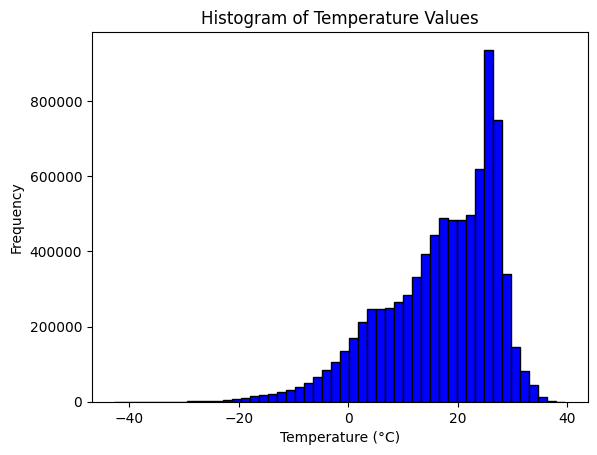

In [13]:
min_temp = float('inf')
max_temp = float('-inf')

all_temperatures = []

# Iterate over each row in the DataFrame
for index, row in processed.iterrows():
    # Convert the string representation of the list to an actual list
    temperatures = ast.literal_eval(row['Temperature'])

    # Find min and max in the list, if the list is not empty
    if temperatures:
        min_temp = min(min_temp, min(temperatures))
        max_temp = max(max_temp, max(temperatures))
    
    # Extend the all_temperatures list with values from this row
    all_temperatures.extend(temperatures)

print(f"Minimum Temperature in Dataset: {min_temp}")
print(f"Maximum Temperature in Dataset: {max_temp}")

plt.hist(all_temperatures, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Temperature Values')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()
